In [11]:
import independent_functions as i_f
import numpy as np

In [12]:
import numpy as np
import math
import scipy.stats as stats
from scipy.linalg import sqrtm
import scipy
import matplotlib.pyplot as plt
import time
import datetime
import random
import statistics

import numba
from numba import jit, njit
from numba.typed import List

In [13]:
alpha = 0.1

# 0.) Functions definitions
##### The order is: 1.) fdep --> 2.) mother --> 3.) plot
#### THE FOLLOWING 3 CELLS ARE 3 FUNCTIONS DEFINED ONLY FOR THE POOLED PROCEDURE. The reason they are defined here and not in the .py file is because they were added only later to the simulation.
##### We define "fdep_marginals_POOLED" because its only for the pooled procedure, suggested to check by ruth

In [14]:
def fdep_marginals_pooled_ruth(alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR):

    block_beta_agg = []
    
    #  columns order: marglocfdrFDR, marglocfdrpFDR, marglocfdrmFDR
    minprob_mat = np.zeros((1,6),float)
    lev_mat = np.zeros((1,6),float) 
    pow_mat = np.zeros((1,6),float) 
    ev_mat = np.zeros((1,6),float) 
    er_mat = np.zeros((1,6),float) 
    
    
    for i in range(len(mu0)):
        # - - - BLOCK BETA - - - creating vector Z from each group, but straight afterwards - concating it
        block_beta = i_f.my_rbeta(num_hypo[i], 
                                prob_to_1[i], 
                                mu0[i], 
                                mu1[i], 
                                variance_0[i], 
                                variance_1[i],
                                False)
        block_beta_agg.append(block_beta)
        
    # concating the Z vectors to a one coherent vector
    block_beta_agg_stacked = np.hstack(block_beta_agg)   
    
    # - - - creating locfdr for the pooled rule - - -
    
    ### NUMERATOR
    first_group_prob = (num_hypo[0])/(num_hypo[0]+num_hypo[1])
    second_group_prob = (num_hypo[1])/(num_hypo[0]+num_hypo[1])
    Ph0 = (1-prob_to_1[0])*(first_group_prob) + (1-prob_to_1[1])*(second_group_prob)
    # Assuming that both null distributions in the 2 groups are the same (mu0 & variance0 has the same values in their 2 indexes of groups), other wise, needed to change to the same logic of partition as Ph0
    dist_0 = stats.norm(mu0[0], np.sqrt(variance_0[0]))
    Pzh0 = dist_0.pdf(block_beta_agg_stacked)

    NUMERATOR = Pzh0*Ph0


    ### DENOMINATOR
    Ph1c1 = prob_to_1[0]*first_group_prob
    Ph1c2 = prob_to_1[1]*second_group_prob

    dist_1_1 = stats.norm(mu1[0], np.sqrt(variance_1[0]))
    Pzh1c1 = dist_1_1.pdf(block_beta_agg_stacked)
    dist_1_2 = stats.norm(mu1[1], np.sqrt(variance_1[1]))
    Pzh1c2 = dist_1_2.pdf(block_beta_agg_stacked)

    DENOMINATOR = NUMERATOR + Pzh1c1*Ph1c1 + Pzh1c2*Ph1c2


    ### marglocfdr
    marglocfdr = NUMERATOR / DENOMINATOR
    
    
    # - - - creating a marginal & b marginal - - - 
    omarglocfdr = np.sort(marglocfdr)
    amarg = 1 - omarglocfdr
    omarglocfdr_numba = numba.typed.List(omarglocfdr)    
    bmarg = np.array(i_f.BZCpp_numba_jit(omarglocfdr_numba)) # it WAS np.array but now it's a LIST of np.arrays so that when you take an index from it, it will be fine
    
    # marglocfdrFDR 
    lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = i_f.FDR_Generic_structure (mus=musMargFDR, a=amarg, b_1=bmarg, 
                                                                               b_2=bmarg, ind=3, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat,  
                                                                               olocfdr_function=omarglocfdr, 
                                                                               alpha = alpha)

    return lev_mat, pow_mat, minprob_mat, ev_mat, er_mat


In [15]:
def mother_procedure_pooled(iter_num, alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar):
    
    start = time.time()    

    # r & s
    #rs_power, rs_fdr, rs_mfdr_V, rs_mfdr_R, rs_pfdr_minprob = [], [], [], [], []
    lev_mat_agg = pow_mat_agg = minprob_mat_agg = ev_mat_agg = er_mat_agg = 0
    
    for i in range(iter_num):
       
        # r & s
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = fdep_marginals_pooled_ruth(alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar)
                                                        
        lev_mat_agg += lev_mat[0]
        pow_mat_agg += pow_mat[0]
        minprob_mat_agg += minprob_mat[0]
        ev_mat_agg += ev_mat[0]
        er_mat_agg += er_mat[0]

    # R & S
    # (IF I UNDERSTAND CORRECTRLY, WITH R & S WE WILL HAVE 3 X 4 = 12 NEW METRICS: EACH OF THE 4 METRIC FOR EACH Err Optimizer)
    pow_mat_r = pow_mat_agg / iter_num
    lev_mat_r = lev_mat_agg / iter_num
    ev_mat_r = ev_mat_agg / iter_num
    er_mat_r = er_mat_agg / iter_num
    minprob_mat_r = minprob_mat_agg / iter_num
    
    ## marginallocfdr FDR control
    rs_margFDR_power_r = pow_mat_r[3]
    rs_margFDR_fdr_r = lev_mat_r[3]
    rs_margFDR_mfdr_r = ev_mat_r[3] / er_mat_r[3]
    rs_margFDR_pfdr_r = lev_mat_r[3] / minprob_mat_r[3]
    
    # FNR for each one of the 5 procedures
    rs_margFDR_fnr_r = i_f.FNR(num_hypo, prob_to_1, er_mat_r[3], ev_mat_r[3]) 
    
    # Arranging the final output
    rs_margFDR_list = [rs_margFDR_power_r, rs_margFDR_fdr_r, rs_margFDR_mfdr_r, rs_margFDR_pfdr_r, rs_margFDR_fnr_r]

    stop = time.time()
    duration = stop-start
    print("TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: " + str(duration))

    return rs_margFDR_list

In [16]:
def plot_metric_pooled(metric_index, metric_tite_str, metric_realizations_x_axis, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR, pooled_rs_margFDR):
    # this function needs as an input a series of NESTED LISTS per policy procedure
    
    slfdr_metric_list = [policy_realization[metric_index] for policy_realization in slfdr]
    clfdr_metric_list = [policy_realization[metric_index] for policy_realization in clfdr]
    rs_margFDR_metric_list = [policy_realization[metric_index] for policy_realization in rs_margFDR]
    rs_margpFDR_metric_list = [policy_realization[metric_index] for policy_realization in rs_margpFDR]
    rs_margmFDR_metric_list = [policy_realization[metric_index] for policy_realization in rs_margmFDR]
    pooled_rs_margFDR_metric_list = [policy_realization[metric_index] for policy_realization in pooled_rs_margFDR]
    
    plt.plot(metric_realizations_x_axis, slfdr_metric_list , 'b-' , label = "SLFDR")
    plt.plot(metric_realizations_x_axis, clfdr_metric_list , 'g--' , label = "CLFDR")
    plt.plot(metric_realizations_x_axis, rs_margFDR_metric_list , 'r-.' , label = "margFDR")
    plt.plot(metric_realizations_x_axis, rs_margpFDR_metric_list , 'k:' , label = "margpFDR")
    plt.plot(metric_realizations_x_axis, rs_margmFDR_metric_list , 'y' , label = "margmFDR")
    plt.plot(metric_realizations_x_axis, pooled_rs_margFDR_metric_list , 'm' , label = "margFDR_pooled")
    
    plt.title(metric_tite_str)
    plt.legend()
    plt.show()

def plot_4_metrics_pooled(p1_simulation, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR, pooled_rs_margFDR):
    # this function needs: the output of the 5 procedures + the X axis simulations change
    
    plot_metric_pooled(0, "Power - E(TP)", p1_simulation, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR, pooled_rs_margFDR)
    plot_metric_pooled(4, "mFNR", p1_simulation, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR, pooled_rs_margFDR)
    plot_metric_pooled(1, "FDR", p1_simulation, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR, pooled_rs_margFDR)
    plot_metric_pooled(2, "mFDR", p1_simulation, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR, pooled_rs_margFDR)
    plot_metric_pooled(3, "pFDR", p1_simulation, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR, pooled_rs_margFDR)

##### --------------------------------------------------------------
##### 0.1.) Mother functions that calculate SE's - 1.) for all procedures without "pooled" 2.) for "pooled"
##### --------------------------------------------------------------

In [17]:
def mother_procedure_SE(iter_num, alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar, musMargPFDR_scalar, musMargMFDR_scalar):
    
    start = time.time()    

    # SLFDR
    slfdr_power, slfdr_fdr, slfdr_mfdr_V, slfdr_mfdr_R, slfdr_pfdr_minprob = [], [], [], [], []
    
    # CLFDR
    clfdr_power, clfdr_fdr, clfdr_mfdr_V, clfdr_mfdr_R, clfdr_pfdr_minprob = [], [], [], [], []
    
    # r & s
    #rs_power, rs_fdr, rs_mfdr_V, rs_mfdr_R, rs_pfdr_minprob = [], [], [], [], []
    #lev_mat_agg = pow_mat_agg = minprob_mat_agg = ev_mat_agg = er_mat_agg = 0
    lev_mat_agg_fdr, pow_mat_agg_fdr, minprob_mat_agg_fdr, ev_mat_agg_fdr, er_mat_agg_fdr = [], [], [], [], []
    lev_mat_agg_pfdr, pow_mat_agg_pfdr, minprob_mat_agg_pfdr, ev_mat_agg_pfdr, er_mat_agg_pfdr = [], [], [], [], []
    lev_mat_agg_mfdr, pow_mat_agg_mfdr, minprob_mat_agg_mfdr, ev_mat_agg_mfdr, er_mat_agg_mfdr = [], [], [], [], []

    for i in range(iter_num):
        #if i == 4999:
        #    print(i)
        # SLFDR
        locfdr_agg, R_sl, V_sl, minprob_sl = i_f.my_SLFDR (alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1)
        
        slfdr_power.append(sum(R_sl) - sum(V_sl))
        if sum(R_sl) > 0:
            slfdr_fdr.append(sum(V_sl) / sum(R_sl))
        else: 
            slfdr_fdr.append(0)
        slfdr_mfdr_V.append(sum(V_sl))
        slfdr_mfdr_R.append(sum(R_sl))
        slfdr_pfdr_minprob.append(minprob_sl)
        
        # CLFDR
        rejections_olocfdr ,R_cl , V_cl, minprob_cl = i_f.my_CLFDR (alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1)

        clfdr_power.append(R_cl - V_cl)
        if R_cl > 0:
            clfdr_fdr.append(V_cl / R_cl)
        else: 
            clfdr_fdr.append(0)
        clfdr_mfdr_V.append(V_cl)
        clfdr_mfdr_R.append(R_cl)
        clfdr_pfdr_minprob.append(minprob_cl)        
        
        # r & s
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = i_f.fdep_marginals_groups (alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar, musMargPFDR_scalar, musMargMFDR_scalar)
        
        # fdr 
        lev_mat_agg_fdr.append(lev_mat[0][3])
        pow_mat_agg_fdr.append(pow_mat[0][3])
        minprob_mat_agg_fdr.append(minprob_mat[0][3])
        ev_mat_agg_fdr.append(ev_mat[0][3])
        er_mat_agg_fdr.append(er_mat[0][3])
                
        # pfdr 
        lev_mat_agg_pfdr.append(lev_mat[0][4])
        pow_mat_agg_pfdr.append(pow_mat[0][4])
        minprob_mat_agg_pfdr.append(minprob_mat[0][4])
        ev_mat_agg_pfdr.append(ev_mat[0][4])
        er_mat_agg_pfdr.append(er_mat[0][4])
        
        # mfdr 
        lev_mat_agg_mfdr.append(lev_mat[0][5])
        pow_mat_agg_mfdr.append(pow_mat[0][5])
        minprob_mat_agg_mfdr.append(minprob_mat[0][5])
        ev_mat_agg_mfdr.append(ev_mat[0][5])
        er_mat_agg_mfdr.append(er_mat[0][5])
        
        
        
    # SLFDR RETURN
    slfdr_power_r = statistics.mean(slfdr_power)
    slfdr_power_r_SE = statistics.stdev(slfdr_power)
    slfdr_fdr_r = statistics.mean(slfdr_fdr)
    slfdr_fdr_r_SE = statistics.stdev(slfdr_fdr)
    if (statistics.mean(slfdr_mfdr_R) != 0) & (statistics.stdev(slfdr_mfdr_R) != 0):
        slfdr_mfdr_r = statistics.mean(slfdr_mfdr_V) / statistics.mean(slfdr_mfdr_R)
        slfdr_mfdr_r_SE = statistics.stdev(slfdr_mfdr_V) / statistics.stdev(slfdr_mfdr_R)
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    else:
        slfdr_mfdr_r = 0
        slfdr_mfdr_r_SE = 0
    if (statistics.mean(slfdr_pfdr_minprob) != 0) & (statistics.stdev(slfdr_pfdr_minprob) != 0):
        slfdr_pfdr_r = slfdr_fdr_r / statistics.mean(slfdr_pfdr_minprob)
        slfdr_pfdr_r_SE = statistics.stdev(slfdr_fdr) / statistics.stdev(slfdr_pfdr_minprob)
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    else:
        slfdr_pfdr_r = 0
        slfdr_pfdr_r_SE = 0

    
    # CLFDR RETURN
    clfdr_power_r = statistics.mean(clfdr_power)
    clfdr_power_r_SE = statistics.stdev(clfdr_power)
    clfdr_fdr_r = statistics.mean(clfdr_fdr)
    clfdr_fdr_r_SE = statistics.stdev(clfdr_fdr)
    if (statistics.mean(clfdr_mfdr_R) != 0) & (statistics.stdev(slfdr_mfdr_R) != 0):
        clfdr_mfdr_r = statistics.mean(clfdr_mfdr_V) / statistics.mean(clfdr_mfdr_R)
        clfdr_mfdr_r_SE = statistics.stdev(clfdr_mfdr_V) / statistics.stdev(clfdr_mfdr_R)
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    else:
        clfdr_mfdr_r = 0
        clfdr_mfdr_r_SE = 0
    if (statistics.mean(clfdr_pfdr_minprob) != 0) & (statistics.stdev(clfdr_pfdr_minprob) != 0):
        clfdr_pfdr_r = clfdr_fdr_r / statistics.mean(clfdr_pfdr_minprob)
        clfdr_pfdr_r_SE = statistics.stdev(clfdr_fdr) / statistics.stdev(clfdr_pfdr_minprob)
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    else:
        clfdr_pfdr_r = 0
        clfdr_pfdr_r_SE = 0    
    
    # R & S RETURN
    # OLD COMMENT - (IF I UNDERSTAND CORRECTRLY, WITH R & S WE WILL HAVE 3 X 4 = 12 NEW METRICS: EACH OF THE 4 METRIC FOR EACH Err Optimizer)
    
    ## marginallocfdr FDR control
    rs_margFDR_power_r = statistics.mean(pow_mat_agg_fdr)
    rs_margFDR_power_r_SE = statistics.stdev(pow_mat_agg_fdr)
    rs_margFDR_fdr_r = statistics.mean(lev_mat_agg_fdr)
    rs_margFDR_fdr_r_SE = statistics.stdev(lev_mat_agg_fdr)
    rs_margFDR_mfdr_r = statistics.mean(ev_mat_agg_fdr) / statistics.mean(er_mat_agg_fdr)
    rs_margFDR_mfdr_r_SE = statistics.stdev(ev_mat_agg_fdr) / statistics.stdev(er_mat_agg_fdr)
    rs_margFDR_pfdr_r = statistics.mean(lev_mat_agg_fdr) / statistics.mean(minprob_mat_agg_fdr) 
    if (statistics.stdev(minprob_mat_agg_fdr) != 0):
        rs_margFDR_pfdr_r_SE = statistics.stdev(lev_mat_agg_fdr) / statistics.stdev(minprob_mat_agg_fdr) 
    else:
        rs_margFDR_pfdr_r_SE = 0
    """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    """ THIS CONDITION IS A LITTLE BIT WEIRD TO ME BUT OK FOR NOW."""

    ## marginallocfdr pFDR control
    rs_margpFDR_power_r = statistics.mean(pow_mat_agg_pfdr) 
    rs_margpFDR_power_r_SE = statistics.stdev(pow_mat_agg_pfdr)
    rs_margpFDR_fdr_r = statistics.mean(lev_mat_agg_pfdr)
    rs_margpFDR_fdr_r_SE = statistics.stdev(lev_mat_agg_pfdr)
    rs_margpFDR_mfdr_r = statistics.mean(ev_mat_agg_pfdr) / statistics.mean(er_mat_agg_pfdr)
    rs_margpFDR_mfdr_r_SE = statistics.stdev(ev_mat_agg_pfdr) / statistics.stdev(er_mat_agg_pfdr)
    rs_margpFDR_pfdr_r = statistics.mean(lev_mat_agg_pfdr) / statistics.mean(minprob_mat_agg_pfdr) 
    if (statistics.stdev(minprob_mat_agg_pfdr) != 0):
        rs_margpFDR_pfdr_r_SE = statistics.stdev(lev_mat_agg_pfdr) / statistics.stdev(minprob_mat_agg_pfdr) 
    else:
        rs_margpFDR_pfdr_r_SE = 0
    """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    """ THIS CONDITION IS A LITTLE BIT WEIRD TO ME BUT OK FOR NOW."""

    ## marginallocfdr mFDR control
    rs_margmFDR_power_r = statistics.mean(pow_mat_agg_mfdr) 
    rs_margmFDR_power_r_SE = statistics.stdev(pow_mat_agg_mfdr)
    rs_margmFDR_fdr_r = statistics.mean(lev_mat_agg_mfdr)
    rs_margmFDR_fdr_r_SE = statistics.stdev(lev_mat_agg_mfdr)
    rs_margmFDR_mfdr_r = statistics.mean(ev_mat_agg_mfdr) / statistics.mean(er_mat_agg_mfdr)
    rs_margmFDR_mfdr_r_SE = statistics.stdev(ev_mat_agg_mfdr) / statistics.stdev(er_mat_agg_mfdr)
    rs_margmFDR_pfdr_r = statistics.mean(lev_mat_agg_mfdr) / statistics.mean(minprob_mat_agg_mfdr) 
    if (statistics.stdev(minprob_mat_agg_mfdr) != 0):
        rs_margmFDR_pfdr_r_SE = statistics.stdev(lev_mat_agg_mfdr) / statistics.stdev(minprob_mat_agg_mfdr) 
    else:
        rs_margmFDR_pfdr_r_SE = 0
    """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    """ THIS CONDITION IS A LITTLE BIT WEIRD TO ME BUT OK FOR NOW."""

    
    # FNR for each one of the 5 procedures
    slfdr_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(slfdr_mfdr_R), statistics.mean(slfdr_mfdr_V))
    clfdr_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(clfdr_mfdr_R), statistics.mean(clfdr_mfdr_V))    
    rs_margFDR_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(er_mat_agg_fdr), statistics.mean(ev_mat_agg_fdr)) 
    rs_margpFDR_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(er_mat_agg_pfdr), statistics.mean(ev_mat_agg_pfdr))
    rs_margmFDR_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(er_mat_agg_mfdr), statistics.mean(ev_mat_agg_mfdr))    
    
    # SE for FNR for each one of the 5 procedures
    """ THE PROBLEM HERE IS THAT I GIVE NUMBER OF HYPO - MIGHT RETURN AN ERROR - not sure """
    slfdr_fnr_r_vec_to_SE, clfdr_fnr_r_vec_to_SE, fdr_fnr_r_vec_to_SE, pfdr_fnr_r_vec_to_SE, mfdr_fnr_r_vec_to_SE = [], [], [], [], []
    for i in range(iter_num): 
        slfdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, slfdr_mfdr_R[i], slfdr_mfdr_V[i]))
        clfdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, clfdr_mfdr_R[i], clfdr_mfdr_V[i]))
        fdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, er_mat_agg_fdr[i], ev_mat_agg_fdr[i]))
        pfdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, er_mat_agg_pfdr[i], ev_mat_agg_pfdr[i]))
        mfdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, er_mat_agg_mfdr[i], ev_mat_agg_mfdr[i]))

    slfdr_fnr_r_SE = statistics.stdev(slfdr_fnr_r_vec_to_SE)
    clfdr_fnr_r_SE = statistics.stdev(clfdr_fnr_r_vec_to_SE)
    fdr_fnr_r_SE = statistics.stdev(fdr_fnr_r_vec_to_SE) 
    pfdr_fnr_r_SE = statistics.stdev(pfdr_fnr_r_vec_to_SE)
    mfdr_fnr_r_SE = statistics.stdev(mfdr_fnr_r_vec_to_SE)
    
    
    # Arranging the final output 
    """HERE I NEED TO ADD SE FOR EACH METRIC! IT WILL DOUBLE THE OUTPUT LENGTH"""
    slfdr_list = [slfdr_power_r, slfdr_power_r_SE, slfdr_fdr_r, slfdr_fdr_r_SE, slfdr_mfdr_r, slfdr_mfdr_r_SE, slfdr_pfdr_r, slfdr_pfdr_r_SE, slfdr_fnr_r, slfdr_fnr_r_SE]
    clfdr_list = [clfdr_power_r, clfdr_power_r_SE, clfdr_fdr_r, clfdr_fdr_r_SE, clfdr_mfdr_r, clfdr_mfdr_r_SE, clfdr_pfdr_r, clfdr_pfdr_r_SE, clfdr_fnr_r, clfdr_fnr_r_SE]
    rs_margFDR_list = [rs_margFDR_power_r, rs_margFDR_power_r_SE, rs_margFDR_fdr_r, rs_margFDR_fdr_r_SE, rs_margFDR_mfdr_r, rs_margFDR_mfdr_r_SE, rs_margFDR_pfdr_r, rs_margFDR_pfdr_r_SE, rs_margFDR_fnr_r, fdr_fnr_r_SE]
    rs_margpFDR_list = [rs_margpFDR_power_r, rs_margpFDR_power_r_SE, rs_margpFDR_fdr_r, rs_margpFDR_fdr_r_SE, rs_margpFDR_mfdr_r, rs_margpFDR_mfdr_r_SE, rs_margpFDR_pfdr_r, rs_margpFDR_pfdr_r_SE, rs_margpFDR_fnr_r, pfdr_fnr_r_SE]
    rs_margmFDR_list = [rs_margmFDR_power_r, rs_margmFDR_power_r_SE, rs_margmFDR_fdr_r, rs_margmFDR_fdr_r_SE, rs_margmFDR_mfdr_r, rs_margmFDR_mfdr_r_SE, rs_margmFDR_pfdr_r, rs_margmFDR_pfdr_r_SE, rs_margmFDR_fnr_r, mfdr_fnr_r_SE]

    stop = time.time()
    duration = stop-start
    print("TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: " + str(duration))
    return  slfdr_list, clfdr_list, rs_margFDR_list, rs_margpFDR_list, rs_margmFDR_list


In [18]:
def mother_procedure_pooled_calc_SE(iter_num, alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar):
    
    start = time.time()    

    # r & s
    #rs_power, rs_fdr, rs_mfdr_V, rs_mfdr_R, rs_pfdr_minprob = [], [], [], [], []
    #lev_mat_agg = pow_mat_agg = minprob_mat_agg = ev_mat_agg = er_mat_agg = 0
    lev_mat_agg_fdr, pow_mat_agg_fdr, minprob_mat_agg_fdr, ev_mat_agg_fdr, er_mat_agg_fdr = [], [], [], [], []
    
    for i in range(iter_num):
       
        # r & s 
        # creating an <iter_num> vector of numbers
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = fdep_marginals_pooled_ruth(alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar)
                                                        
        lev_mat_agg_fdr.append(lev_mat[0][3])
        pow_mat_agg_fdr.append(pow_mat[0][3])
        minprob_mat_agg_fdr.append(minprob_mat[0][3])
        ev_mat_agg_fdr.append(ev_mat[0][3])
        er_mat_agg_fdr.append(er_mat[0][3])

#     # R & S
#     # (IF I UNDERSTAND CORRECTRLY, WITH R & S WE WILL HAVE 3 X 4 = 12 NEW METRICS: EACH OF THE 4 METRIC FOR EACH Err Optimizer)
    
    ## oded - January 2023 - it looks like FDR, so ill just write it as "FDR" although its the pooled version
    
    ## marginallocfdr FDR control
    rs_margFDR_power_r = statistics.mean(pow_mat_agg_fdr)
    rs_margFDR_power_r_SE = statistics.stdev(pow_mat_agg_fdr)
    rs_margFDR_fdr_r = statistics.mean(lev_mat_agg_fdr)
    rs_margFDR_fdr_r_SE = statistics.stdev(lev_mat_agg_fdr)
    rs_margFDR_mfdr_r = statistics.mean(ev_mat_agg_fdr) / statistics.mean(er_mat_agg_fdr)
    rs_margFDR_mfdr_r_SE = statistics.stdev(ev_mat_agg_fdr) / statistics.stdev(er_mat_agg_fdr)
    rs_margFDR_pfdr_r = statistics.mean(lev_mat_agg_fdr) / statistics.mean(minprob_mat_agg_fdr) 
    if (statistics.stdev(minprob_mat_agg_fdr) != 0):
        rs_margFDR_pfdr_r_SE = statistics.stdev(lev_mat_agg_fdr) / statistics.stdev(minprob_mat_agg_fdr) 
    else:
        rs_margFDR_pfdr_r_SE = 0
    """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    """ THIS CONDITION IS A LITTLE BIT WEIRD TO ME BUT OK FOR NOW."""
    
    # FNR for each one of the 5 procedures
    rs_margFDR_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(er_mat_agg_fdr), statistics.mean(ev_mat_agg_fdr)) 

    # SE for FNR for each one of the 5 procedures
    """ THE PROBLEM HERE IS THAT I GIVE NUMBER OF HYPO - MIGHT RETURN AN ERROR - not sure """
    fdr_fnr_r_vec_to_SE = []
    for i in range(iter_num): 
        fdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, er_mat_agg_fdr[i], ev_mat_agg_fdr[i]))
        
    fdr_fnr_r_SE = statistics.stdev(fdr_fnr_r_vec_to_SE) 
        
    # Arranging the final output
    rs_margFDR_list = [rs_margFDR_power_r, rs_margFDR_power_r_SE, rs_margFDR_fdr_r, rs_margFDR_fdr_r_SE, rs_margFDR_mfdr_r, rs_margFDR_mfdr_r_SE, rs_margFDR_pfdr_r, rs_margFDR_pfdr_r_SE, rs_margFDR_fnr_r, fdr_fnr_r_SE]

    stop = time.time()
    duration = stop-start
    print("TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: " + str(duration))

    return rs_margFDR_list

In [19]:
def present_max_SE (string, list_input):
    
    max_power = max(list_input[0][0],list_input[1][0],list_input[2][0])
    print(f"for pocedure {string}, the maximal SE for Power(E(TP)) is:" + str(max_power))
    
    max_fdr = max(list_input[0][1],list_input[1][1],list_input[2][1])
    print(f"for pocedure {string}, the maximal SE for FDR is:" + str(max_fdr))
    
    max_mfdr = max(list_input[0][2],list_input[1][2],list_input[2][2])
    print(f"for pocedure {string}, the maximal SE for mFDR is:" + str(max_mfdr) )
    
    max_pfdr = max(list_input[0][3],list_input[1][3],list_input[2][3])
    print(f"for pocedure {string}, the maximal SE for pFDR is:" + str(max_pfdr))
    
    max_fnr = max(list_input[0][4],list_input[1][4],list_input[2][4])
    print(f"for pocedure {string}, the maximal SE for fnr is:" + str(max_fnr))


# present_max_SE("SLFDR",slfdr_SE11)

for pocedure SLFDR, the maximal SE for Power(E(TP)) is:6.557438524302
for pocedure SLFDR, the maximal SE for FDR is:0.03482630270616463
for pocedure SLFDR, the maximal SE for mFDR is:0.24439866770775875
for pocedure SLFDR, the maximal SE for pFDR is:0
for pocedure SLFDR, the maximal SE for fnr is:0.011474362334766399


## ---------------------------------
## 1.)  Cai & sun 09' setting - Study 1# --- 1
## ---------------------------------

In [20]:
# Cai & sun 09' setting - Study 1# --- 1

#prob_to_1 = [x, 0.1]
#x = [0.03, 0.15, 0.27]

num_hypo = [300, 150]

mu0 = [0, 0]
mu1 = [-2, 4]

variance_0 = [1, 1]
variance_1 = [1, 1]

In [21]:
# Simulation values

# P1
p1_simulation_3sample = [0.03, 0.15, 0.27]

# Procedure Mu's
## FINAL ONE 5000
musMargFDR_scalar_3sample1 = [20.77625035, 110.151526, 222.9157326]  
## FINAL ONE 5000
musMargPFDR_scalar_3sample1 = [20.7761942, 110.1745642, 222.9248442]
## FINAL ONE 5000
musMargMFDR_scalar_3sample1 = [1.14268804, 3.18147896, 3.604765066]
## FINAL ONE 5000
musMargFDR_pooled_scalar_3sample1 = [21.54916206, 100.4398176, 208.5391733]

In [22]:
%%time
# simulation #1, study 1#: varying the probability of only the 1st group

slfdr = []
clfdr = []
rs_margFDR = []
rs_margpFDR = []
rs_margmFDR = []
rs_margpFDR_pooled = []

for i in range(len(p1_simulation_3sample)):
    
    prob_to_1 = [p1_simulation_3sample[i], 0.1]
    musMargFDR_scalar = [musMargFDR_scalar_3sample1[i]]
    musMargPFDR_scalar = [musMargPFDR_scalar_3sample1[i]] 
    musMargMFDR_scalar = [musMargMFDR_scalar_3sample1[i]]
    musMargFDR_pooled_scalar = [musMargFDR_pooled_scalar_3sample1[i]]
    
    slfdr_list, clfdr_list, rs_margFDR_list, rs_margpFDR_list, rs_margmFDR_list = mother_procedure_SE(5000, alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar, musMargPFDR_scalar, musMargMFDR_scalar) # i_f.mother_procedure
    rs_margFDR_pooled_list = mother_procedure_pooled_calc_SE(5000, alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar)
    
    
    slfdr.append(slfdr_list)
    clfdr.append(clfdr_list)
    rs_margFDR.append(rs_margFDR_list)
    rs_margpFDR.append(rs_margpFDR_list)
    rs_margmFDR.append(rs_margmFDR_list)
    rs_margpFDR_pooled.append(rs_margFDR_pooled_list)

TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 86.60148525238037
TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 33.447832107543945
TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 84.18257069587708
TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 32.526350021362305
TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 96.93202447891235
TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 34.877901554107666
Wall time: 6min 8s


In [23]:
# slfdr[0][0]

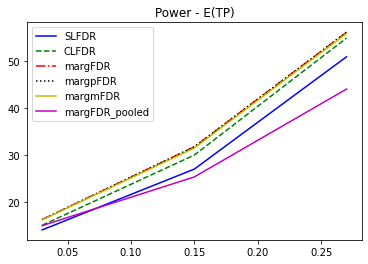

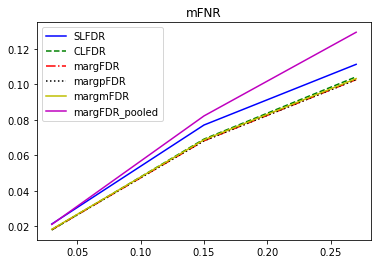

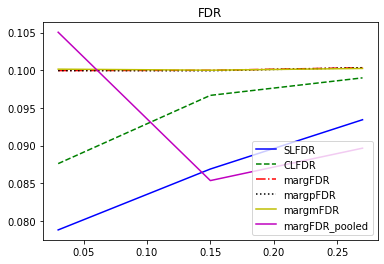

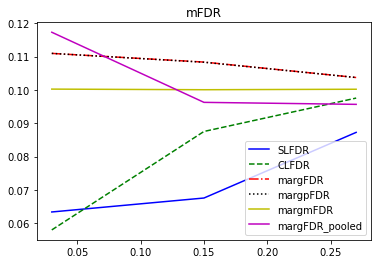

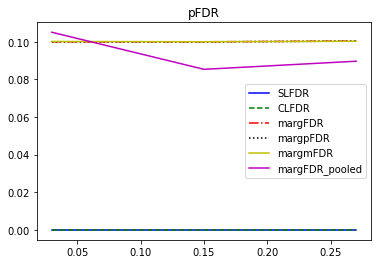

Wall time: 942 ms


In [24]:
%%time

slfdr_, slfdr_SE, clfdr_, clfdr_SE, rs_margFDR_, rs_margFDR_SE, rs_margpFDR_ , rs_margpFDR_SE = [],[],[],[],[],[],[],[]
rs_margmFDR_, rs_margmFDR_SE, rs_margpFDR_pooled_, rs_margpFDR_pooled_SE =  [],[],[],[]

for i in range(len(p1_simulation_3sample)):
    slfdr_.append([slfdr[i][0], slfdr[i][2], slfdr[i][4], slfdr[i][6], slfdr[i][8]])
    slfdr_SE.append([slfdr[i][1], slfdr[i][3], slfdr[i][5], slfdr[i][7], slfdr[i][9]])
    clfdr_.append([clfdr[i][0], clfdr[i][2], clfdr[i][4], clfdr[i][6], clfdr[i][8]])
    clfdr_SE.append([clfdr[i][1], clfdr[i][3], clfdr[i][5], clfdr[i][7], clfdr[i][9]])
    rs_margFDR_.append([rs_margFDR[i][0], rs_margFDR[i][2], rs_margFDR[i][4], rs_margFDR[i][6], rs_margFDR[i][8]])
    rs_margFDR_SE.append([rs_margFDR[i][1], rs_margFDR[i][3], rs_margFDR[i][5], rs_margFDR[i][7], rs_margFDR[i][9]]) 
    rs_margpFDR_.append([rs_margpFDR[i][0], rs_margpFDR[i][2], rs_margpFDR[i][4], rs_margpFDR[i][6], rs_margpFDR[i][8]])
    rs_margpFDR_SE.append([rs_margpFDR[i][1], rs_margpFDR[i][3], rs_margpFDR[i][5], rs_margpFDR[i][7], rs_margpFDR[i][9]]) 
    rs_margmFDR_.append([rs_margmFDR[i][0], rs_margmFDR[i][2], rs_margmFDR[i][4], rs_margmFDR[i][6], rs_margmFDR[i][8]])
    rs_margmFDR_SE.append([rs_margmFDR[i][1], rs_margmFDR[i][3], rs_margmFDR[i][5], rs_margmFDR[i][7], rs_margmFDR[i][9]])  
    rs_margpFDR_pooled_.append([rs_margpFDR_pooled[i][0], rs_margpFDR_pooled[i][2], rs_margpFDR_pooled[i][4], rs_margpFDR_pooled[i][6], rs_margpFDR_pooled[i][8]]) 
    rs_margpFDR_pooled_SE.append([rs_margpFDR_pooled[i][1], rs_margpFDR_pooled[i][3], rs_margpFDR_pooled[i][5], rs_margpFDR_pooled[i][7], rs_margpFDR_pooled[i][9]])  


plot_4_metrics_pooled(p1_simulation_3sample, slfdr_, clfdr_, rs_margFDR_, rs_margpFDR_, rs_margmFDR_, rs_margpFDR_pooled_)

#### SE's
## Important remark: these are SD's. to get the SE's one should devide by (5000)^0.5

In [25]:
slfdr_SE, clfdr_SE, rs_margFDR_SE, rs_margpFDR_SE, rs_margmFDR_SE, rs_margpFDR_pooled_SE

([[3.7416573867739413, 0.05719105460600603, 0.0, 0, 0.008461998452594204],
  [5.477225575051661,
   0.048028800768920285,
   0.23769909748997958,
   0,
   0.012173853854151236],
  [7.483314773547883,
   0.03649307806968854,
   0.25103691583694365,
   0,
   0.01697233345212786]],
 [[4.0, 0.061422233609340925, 0.2282377481568034, 0, 0.009344905795386691],
  [5.744562646538029,
   0.048425409614499454,
   0.2809436854350489,
   0,
   0.013000293741315025],
  [7.54983443527075,
   0.03651259644286699,
   0.27787114802529184,
   0,
   0.01748437621709225]],
 [[4.290854282691965,
   0.05644061930252999,
   0.29554112242081787,
   0,
   0.009748164776533107],
  [7.86308743302417,
   0.037162736477965384,
   0.2325425318952108,
   0,
   0.017415275911227233],
  [9.865253720565365,
   0.02325940568875866,
   0.20720877739819307,
   0,
   0.022317658924797812]],
 [[4.290854282691965,
   0.05644061930252999,
   0.29554112242081787,
   0,
   0.009748164776533107],
  [7.866016621791914,
   0.037158

In [26]:
present_max_SE("SLFDR_simu1",slfdr_SE)
present_max_SE("CLFDR_simu1",clfdr_SE)
present_max_SE("margFDR_simu1",rs_margFDR_SE)
present_max_SE("margpFDR_simu1",rs_margpFDR_SE)
present_max_SE("margmFDR_simu1",rs_margmFDR_SE)
present_max_SE("margpFDR_pooled_simu1",rs_margpFDR_pooled_SE)

for pocedure SLFDR_simu1, the maximal SE for Power(E(TP)) is:7.483314773547883
for pocedure SLFDR_simu1, the maximal SE for FDR is:0.05719105460600603
for pocedure SLFDR_simu1, the maximal SE for mFDR is:0.25103691583694365
for pocedure SLFDR_simu1, the maximal SE for pFDR is:0
for pocedure SLFDR_simu1, the maximal SE for fnr is:0.01697233345212786
for pocedure CLFDR_simu1, the maximal SE for Power(E(TP)) is:7.54983443527075
for pocedure CLFDR_simu1, the maximal SE for FDR is:0.061422233609340925
for pocedure CLFDR_simu1, the maximal SE for mFDR is:0.2809436854350489
for pocedure CLFDR_simu1, the maximal SE for pFDR is:0
for pocedure CLFDR_simu1, the maximal SE for fnr is:0.01748437621709225
for pocedure margFDR_simu1, the maximal SE for Power(E(TP)) is:9.865253720565365
for pocedure margFDR_simu1, the maximal SE for FDR is:0.05644061930252999
for pocedure margFDR_simu1, the maximal SE for mFDR is:0.29554112242081787
for pocedure margFDR_simu1, the maximal SE for pFDR is:0
for pocedure

### 1.2.) August 2022 - numbers for a potential table report 

In [27]:
p1_simulation_3sample, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR, rs_margpFDR_pooled

([0.03, 0.15, 0.27],
 [[14,
   3.7416573867739413,
   0.07879015529661632,
   0.05719105460600603,
   0.06334967755014127,
   0.0,
   0,
   0,
   0.021221303935887923,
   0.008461998452594204],
  [27,
   5.477225575051661,
   0.08687827429348098,
   0.048028800768920285,
   0.06753973024631739,
   0.23769909748997958,
   0,
   0,
   0.07704267345531911,
   0.012173853854151236],
  [51,
   7.483314773547883,
   0.09342706622320593,
   0.03649307806968854,
   0.08724724473201137,
   0.25103691583694365,
   0,
   0,
   0.11126186554537963,
   0.01697233345212786]],
 [[15,
   4.0,
   0.08759745997558271,
   0.061422233609340925,
   0.05796227814938038,
   0.2282377481568034,
   0,
   0,
   0.01790282275526092,
   0.009344905795386691],
  [30,
   5.744562646538029,
   0.09666316279693335,
   0.048425409614499454,
   0.08752224523733115,
   0.2809436854350489,
   0,
   0,
   0.06909167883422375,
   0.013000293741315025],
  [55,
   7.54983443527075,
   0.09898851743222659,
   0.03651259644286

## ---------------------------------
## 2.) Cai & sun 09' setting - Study 1# --- 2 - WITH 0.25
## ---------------------------------

In [28]:
# Cai & sun 09' setting - Study 1# --- 2

# mu1 = [x, 2]
# x = [-4.75, -3.75, -2.75]

num_hypo = [300, 150]
prob_to_1 = [0.2, 0.1]

mu0 = [0, 0]

variance_0 = [1, 1]
variance_1 = [1, 0.25] ###### THIS WAS THE PROBLEM. THIS IS THE REAL DATA ( [1, 0.25] ), BUT I SIMULATED [1,1]!!!

In [29]:
# Simulation values

# MU1
mu1_simulation_3sample = [-4.75, -3.75, -2.75]

# Procedure Mu's
## FINAL ONE 5000
musMargFDR_scalar_3sample2 = [39.56583164, 63.60240614, 136.2131459]  
## FINAL ONE 5000
musMargPFDR_scalar_3sample2 = [39.43002387, 63.16025764, 136.5530139]
## FINAL ONE 5000
musMargMFDR_scalar_3sample2 = [0.5189211181, 0.8880115947, 2.458866033]

In [30]:
%%time
# simulation #2, study 1#: varying the MU1 

slfdr = []
clfdr = []
rs_margFDR = []
rs_margpFDR = []
rs_margmFDR = []


for i in range(len(mu1_simulation_3sample)):
    
    mu1 = [mu1_simulation_3sample[i], 2]
    musMargFDR_scalar = [musMargFDR_scalar_3sample2[i]]
    musMargPFDR_scalar = [musMargPFDR_scalar_3sample2[i]] 
    musMargMFDR_scalar = [musMargMFDR_scalar_3sample2[i]]
    
    slfdr_list, clfdr_list, rs_margFDR_list, rs_margpFDR_list, rs_margmFDR_list = mother_procedure_SE(5000, alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar, musMargPFDR_scalar, musMargMFDR_scalar)
    
    slfdr.append(slfdr_list)
    clfdr.append(clfdr_list)
    rs_margFDR.append(rs_margFDR_list)
    rs_margpFDR.append(rs_margpFDR_list)
    rs_margmFDR.append(rs_margmFDR_list)

TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 91.35109114646912
TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 84.70716547966003
TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 87.72787380218506
Wall time: 4min 23s


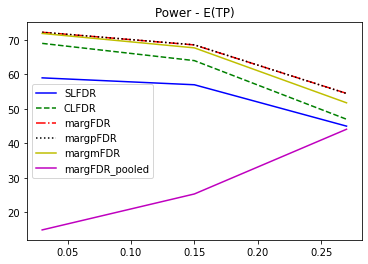

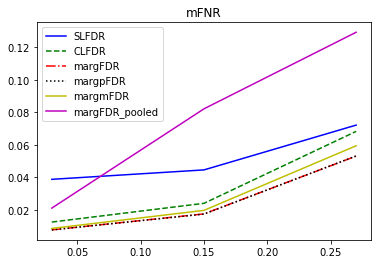

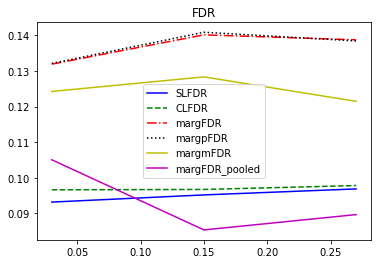

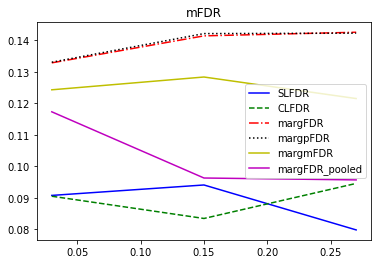

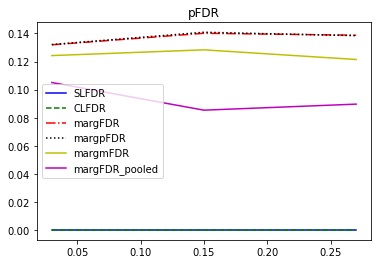

Wall time: 783 ms


In [31]:
%%time

slfdr_, slfdr_SE, clfdr_, clfdr_SE, rs_margFDR_, rs_margFDR_SE, rs_margpFDR_ , rs_margpFDR_SE = [],[],[],[],[],[],[],[]
rs_margmFDR_, rs_margmFDR_SE, rs_margpFDR_pooled_, rs_margpFDR_pooled_SE =  [],[],[],[]

for i in range(len(mu1_simulation_3sample)):
    slfdr_.append([slfdr[i][0], slfdr[i][2], slfdr[i][4], slfdr[i][6], slfdr[i][8]])
    slfdr_SE.append([slfdr[i][1], slfdr[i][3], slfdr[i][5], slfdr[i][7], slfdr[i][9]])
    clfdr_.append([clfdr[i][0], clfdr[i][2], clfdr[i][4], clfdr[i][6], clfdr[i][8]])
    clfdr_SE.append([clfdr[i][1], clfdr[i][3], clfdr[i][5], clfdr[i][7], clfdr[i][9]])
    rs_margFDR_.append([rs_margFDR[i][0], rs_margFDR[i][2], rs_margFDR[i][4], rs_margFDR[i][6], rs_margFDR[i][8]])
    rs_margFDR_SE.append([rs_margFDR[i][1], rs_margFDR[i][3], rs_margFDR[i][5], rs_margFDR[i][7], rs_margFDR[i][9]]) 
    rs_margpFDR_.append([rs_margpFDR[i][0], rs_margpFDR[i][2], rs_margpFDR[i][4], rs_margpFDR[i][6], rs_margpFDR[i][8]])
    rs_margpFDR_SE.append([rs_margpFDR[i][1], rs_margpFDR[i][3], rs_margpFDR[i][5], rs_margpFDR[i][7], rs_margpFDR[i][9]]) 
    rs_margmFDR_.append([rs_margmFDR[i][0], rs_margmFDR[i][2], rs_margmFDR[i][4], rs_margmFDR[i][6], rs_margmFDR[i][8]])
    rs_margmFDR_SE.append([rs_margmFDR[i][1], rs_margmFDR[i][3], rs_margmFDR[i][5], rs_margmFDR[i][7], rs_margmFDR[i][9]])  
    rs_margpFDR_pooled_.append([rs_margpFDR_pooled[i][0], rs_margpFDR_pooled[i][2], rs_margpFDR_pooled[i][4], rs_margpFDR_pooled[i][6], rs_margpFDR_pooled[i][8]]) 
    rs_margpFDR_pooled_SE.append([rs_margpFDR_pooled[i][1], rs_margpFDR_pooled[i][3], rs_margpFDR_pooled[i][5], rs_margpFDR_pooled[i][7], rs_margpFDR_pooled[i][9]])  


i_f.plot_4_metrics(p1_simulation_3sample, slfdr_, clfdr_, rs_margFDR_, rs_margpFDR_, rs_margmFDR_) #, rs_margpFDR_pooled_)

# %%time
# i_f.plot_4_metrics(mu1_simulation_3sample, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR)

#### SE's 
## Important remark: these are SD's. to get the SE's one should devide by (5000)^0.5

In [32]:
slfdr_SE, clfdr_SE, rs_margFDR_SE, rs_margpFDR_SE, rs_margmFDR_SE, rs_margpFDR_pooled_SE

([[6.855654600401044,
   0.018621257493765093,
   0.18793022778918778,
   0,
   0.017159852740895227],
  [7.0, 0.028406217983062938, 0.22895802310431632, 0, 0.017502187221215153],
  [6.6332495807108,
   0.03923924486472217,
   0.2837610416798718,
   0,
   0.015472516776190683]],
 [[7.874007874011811,
   0.02808418634829613,
   0.264768949816476,
   0,
   0.020926649976714062],
  [7.745966692414834,
   0.030832947767429376,
   0.26747883696660185,
   0,
   0.020134838632760166],
  [7.211102550927978,
   0.03898142730437948,
   0.260763459990804,
   0,
   0.016949440103890604]],
 [[7.6063984965802955,
   0.02551699243405256,
   0.301869142236524,
   0,
   0.020631038062659774],
  [7.528580865270542,
   0.025752934204768405,
   0.30370316289699417,
   0,
   0.01993545084936007],
  [8.615324727646284,
   0.030153079108907736,
   0.2768879031238843,
   0,
   0.020675988863755688]],
 [[7.605720505827068,
   0.025559410257772985,
   0.3024706832587414,
   0,
   0.020631248341839294],
  [7.521

In [33]:
present_max_SE("SLFDR_simu2",slfdr_SE)
present_max_SE("CLFDR_simu2",clfdr_SE)
present_max_SE("margFDR_simu2",rs_margFDR_SE)
present_max_SE("margpFDR_simu2",rs_margpFDR_SE)
present_max_SE("margmFDR_simu2",rs_margmFDR_SE)
#present_max_SE("margpFDR_pooled_simu2",rs_margpFDR_pooled_SE)

for pocedure SLFDR_simu2, the maximal SE for Power(E(TP)) is:7.0
for pocedure SLFDR_simu2, the maximal SE for FDR is:0.03923924486472217
for pocedure SLFDR_simu2, the maximal SE for mFDR is:0.2837610416798718
for pocedure SLFDR_simu2, the maximal SE for pFDR is:0
for pocedure SLFDR_simu2, the maximal SE for fnr is:0.017502187221215153
for pocedure CLFDR_simu2, the maximal SE for Power(E(TP)) is:7.874007874011811
for pocedure CLFDR_simu2, the maximal SE for FDR is:0.03898142730437948
for pocedure CLFDR_simu2, the maximal SE for mFDR is:0.26747883696660185
for pocedure CLFDR_simu2, the maximal SE for pFDR is:0
for pocedure CLFDR_simu2, the maximal SE for fnr is:0.020926649976714062
for pocedure margFDR_simu2, the maximal SE for Power(E(TP)) is:8.615324727646284
for pocedure margFDR_simu2, the maximal SE for FDR is:0.030153079108907736
for pocedure margFDR_simu2, the maximal SE for mFDR is:0.30370316289699417
for pocedure margFDR_simu2, the maximal SE for pFDR is:0
for pocedure margFDR_si

### 2.1.) August 2022 - numbers for a potential table report

In [34]:
mu1_simulation_3sample, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR

([-4.75, -3.75, -2.75],
 [[59,
   6.855654600401044,
   0.09316051744579933,
   0.018621257493765093,
   0.09072461752013329,
   0.18793022778918778,
   0,
   0,
   0.03872655495748773,
   0.017159852740895227],
  [57,
   7.0,
   0.09517774534577393,
   0.028406217983062938,
   0.09404359233983593,
   0.22895802310431632,
   0,
   0,
   0.04453601477784298,
   0.017502187221215153],
  [45,
   6.6332495807108,
   0.09686267053324259,
   0.03923924486472217,
   0.07975372051106183,
   0.2837610416798718,
   0,
   0,
   0.0721418467528466,
   0.015472516776190683]],
 [[69,
   7.874007874011811,
   0.09661135476691461,
   0.02808418634829613,
   0.09046569153266976,
   0.264768949816476,
   0,
   0,
   0.012405581411326111,
   0.020926649976714062],
  [64,
   7.745966692414834,
   0.09671201571121087,
   0.030832947767429376,
   0.08339263476249777,
   0.26747883696660185,
   0,
   0,
   0.023941730643891608,
   0.020134838632760166],
  [47,
   7.211102550927978,
   0.09780756804660534,
  

## --------------------------
## 3.) ODED setting - Study 2# (3 groups) --- 1 
## --------------------------

In [35]:
# ODED setting - Study 2# --- 1 (3 groups)

# prob_to_1 = [x, 0.1, 0.1]
# x = [0.03, 0.15, 0.27]

num_hypo = [50, 400, 150]

mu0 = [0, 0, 0]
mu1 = [-2, 4, 1]

variance_0 = [1, 1, 1]
variance_1 = [1, 1, 1]

In [36]:
# Simulation values

# P1
p1_simulation_3sample2 = [0.03, 0.15, 0.27]

# Procedure Mu's
## FINAL ONE 5000
musMargFDR_scalar_3sample3 = [35.87049541, 47.96671729, 60.95742965]  
## FINAL ONE 5000
musMargPFDR_scalar_3sample3 = [35.884, 47.92851388, 60.92526975]
## FINAL ONE 5000
musMargMFDR_scalar_3sample3 = [0.793599797504492, 0.9954546849, 1.151109616] 

In [37]:
%%time
# simulation #1, study 2#: varying the probability of only the 1st group

slfdr = []
clfdr = []
rs_margFDR = []
rs_margpFDR = []
rs_margmFDR = []


for i in range(len(p1_simulation_3sample2)):
    
    prob_to_1 = [p1_simulation_3sample2[i], 0.1, 0.1]
    musMargFDR_scalar = [musMargFDR_scalar_3sample3[i]]
    musMargPFDR_scalar = [musMargPFDR_scalar_3sample3[i]] 
    musMargMFDR_scalar = [musMargMFDR_scalar_3sample3[i]]
    
    slfdr_list, clfdr_list, rs_margFDR_list, rs_margpFDR_list, rs_margmFDR_list = mother_procedure_SE(5000, alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar, musMargPFDR_scalar, musMargMFDR_scalar)
    
    slfdr.append(slfdr_list)
    clfdr.append(clfdr_list)
    rs_margFDR.append(rs_margFDR_list)
    rs_margpFDR.append(rs_margpFDR_list)
    rs_margmFDR.append(rs_margmFDR_list)

TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 128.20842266082764
TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 136.32572078704834
TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 127.59260058403015
Wall time: 6min 32s


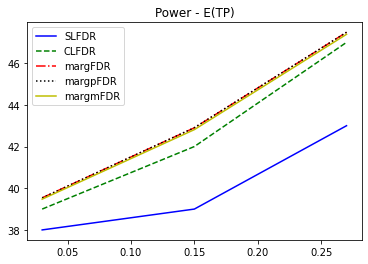

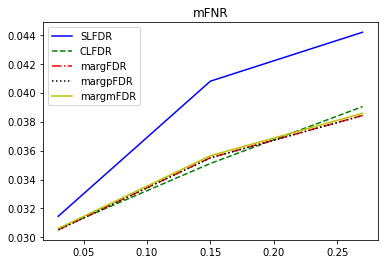

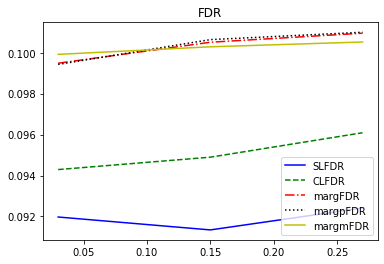

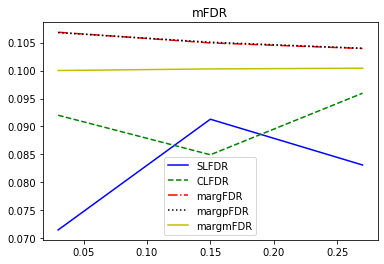

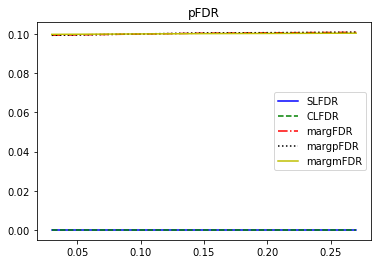

Wall time: 734 ms


In [43]:
%%time

slfdr_, slfdr_SE, clfdr_, clfdr_SE, rs_margFDR_, rs_margFDR_SE, rs_margpFDR_ , rs_margpFDR_SE = [],[],[],[],[],[],[],[]
rs_margmFDR_, rs_margmFDR_SE, rs_margpFDR_pooled_, rs_margpFDR_pooled_SE =  [],[],[],[]

for i in range(len(mu1_simulation_3sample)):
    slfdr_.append([slfdr[i][0], slfdr[i][2], slfdr[i][4], slfdr[i][6], slfdr[i][8]])
    slfdr_SE.append([slfdr[i][1], slfdr[i][3], slfdr[i][5], slfdr[i][7], slfdr[i][9]])
    clfdr_.append([clfdr[i][0], clfdr[i][2], clfdr[i][4], clfdr[i][6], clfdr[i][8]])
    clfdr_SE.append([clfdr[i][1], clfdr[i][3], clfdr[i][5], clfdr[i][7], clfdr[i][9]])
    rs_margFDR_.append([rs_margFDR[i][0], rs_margFDR[i][2], rs_margFDR[i][4], rs_margFDR[i][6], rs_margFDR[i][8]])
    rs_margFDR_SE.append([rs_margFDR[i][1], rs_margFDR[i][3], rs_margFDR[i][5], rs_margFDR[i][7], rs_margFDR[i][9]]) 
    rs_margpFDR_.append([rs_margpFDR[i][0], rs_margpFDR[i][2], rs_margpFDR[i][4], rs_margpFDR[i][6], rs_margpFDR[i][8]])
    rs_margpFDR_SE.append([rs_margpFDR[i][1], rs_margpFDR[i][3], rs_margpFDR[i][5], rs_margpFDR[i][7], rs_margpFDR[i][9]]) 
    rs_margmFDR_.append([rs_margmFDR[i][0], rs_margmFDR[i][2], rs_margmFDR[i][4], rs_margmFDR[i][6], rs_margmFDR[i][8]])
    rs_margmFDR_SE.append([rs_margmFDR[i][1], rs_margmFDR[i][3], rs_margmFDR[i][5], rs_margmFDR[i][7], rs_margmFDR[i][9]])  
    rs_margpFDR_pooled_.append([rs_margpFDR_pooled[i][0], rs_margpFDR_pooled[i][2], rs_margpFDR_pooled[i][4], rs_margpFDR_pooled[i][6], rs_margpFDR_pooled[i][8]]) 
    rs_margpFDR_pooled_SE.append([rs_margpFDR_pooled[i][1], rs_margpFDR_pooled[i][3], rs_margpFDR_pooled[i][5], rs_margpFDR_pooled[i][7], rs_margpFDR_pooled[i][9]])  


i_f.plot_4_metrics(p1_simulation_3sample, slfdr_, clfdr_, rs_margFDR_, rs_margpFDR_, rs_margmFDR_) #, rs_margpFDR_pooled_)

# %%time
# i_f.plot_4_metrics(mu1_simulation_3sample, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR)
# %%time
# i_f.plot_4_metrics(p1_simulation_3sample2, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR)

#### SE's 
## Important remark: these are SD's. to get the SE's one should devide by (5000)^0.5

In [39]:
slfdr_SE, clfdr_SE, rs_margFDR_SE, rs_margpFDR_SE, rs_margmFDR_SE, rs_margpFDR_pooled_SE

([[6.0, 0.035230758428705655, 0.21882130247166223, 0, 0.010406021830846284],
  [6.324555320336759,
   0.03430515214907496,
   0.20720689171764212,
   0,
   0.010940545743304601],
  [6.48074069840786,
   0.0340059255318884,
   0.24596745853331137,
   0,
   0.01131183384428358]],
 [[6.164414002968976,
   0.03643070041251461,
   0.21232970112613472,
   0,
   0.010776314298972304],
  [6.48074069840786,
   0.03714290023078083,
   0.2470833088322774,
   0,
   0.011355059700523347],
  [6.855654600401044,
   0.036165991190608704,
   0.23409541818715363,
   0,
   0.01213457055690567]],
 [[6.658265108783036,
   0.048198490453461765,
   0.38526931088521316,
   0,
   0.011559715708197027],
  [6.874993663660887,
   0.03723040203270926,
   0.2979006811599199,
   0,
   0.011946149756392715],
  [7.147576185178583,
   0.03056294039027353,
   0.26419998661443694,
   0,
   0.012490493796642665]],
 [[6.656683434871187,
   0.048166224204388854,
   0.3850080176018395,
   0,
   0.011556623610859972],
  [6.87

In [40]:
present_max_SE("SLFDR_simu3",slfdr_SE)
present_max_SE("CLFDR_simu3",clfdr_SE)
present_max_SE("margFDR_simu3",rs_margFDR_SE)
present_max_SE("margpFDR_simu3",rs_margpFDR_SE)
present_max_SE("margmFDR_simu3",rs_margmFDR_SE)
#present_max_SE("margpFDR_pooled_simu3",rs_margpFDR_pooled_SE)

for pocedure SLFDR_simu3, the maximal SE for Power(E(TP)) is:6.48074069840786
for pocedure SLFDR_simu3, the maximal SE for FDR is:0.035230758428705655
for pocedure SLFDR_simu3, the maximal SE for mFDR is:0.24596745853331137
for pocedure SLFDR_simu3, the maximal SE for pFDR is:0
for pocedure SLFDR_simu3, the maximal SE for fnr is:0.01131183384428358
for pocedure CLFDR_simu3, the maximal SE for Power(E(TP)) is:6.855654600401044
for pocedure CLFDR_simu3, the maximal SE for FDR is:0.03714290023078083
for pocedure CLFDR_simu3, the maximal SE for mFDR is:0.2470833088322774
for pocedure CLFDR_simu3, the maximal SE for pFDR is:0
for pocedure CLFDR_simu3, the maximal SE for fnr is:0.01213457055690567
for pocedure margFDR_simu3, the maximal SE for Power(E(TP)) is:7.147576185178583
for pocedure margFDR_simu3, the maximal SE for FDR is:0.048198490453461765
for pocedure margFDR_simu3, the maximal SE for mFDR is:0.38526931088521316
for pocedure margFDR_simu3, the maximal SE for pFDR is:0
for pocedur

### 3.1.) August 2022 - numbers for a potential table report

In [41]:
p1_simulation_3sample2, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR

([0.03, 0.15, 0.27],
 [[38,
   6.0,
   0.0919743570773882,
   0.035230758428705655,
   0.07152291355740667,
   0.21882130247166223,
   0,
   0,
   0.03145816705653238,
   0.010406021830846284],
  [39,
   6.324555320336759,
   0.09134432914455463,
   0.03430515214907496,
   0.09129918743723181,
   0.20720689171764212,
   0,
   0,
   0.04079196242996973,
   0.010940545743304601],
  [43,
   6.48074069840786,
   0.09241575270746233,
   0.0340059255318884,
   0.0831217192896418,
   0.24596745853331137,
   0,
   0,
   0.04417245991775716,
   0.01131183384428358]],
 [[39,
   6.164414002968976,
   0.09429161190924243,
   0.03643070041251461,
   0.09201155665151543,
   0.21232970112613472,
   0,
   0,
   0.030595449782149012,
   0.010776314298972304],
  [42,
   6.48074069840786,
   0.09489683570204814,
   0.03714290023078083,
   0.08494769345775338,
   0.2470833088322774,
   0,
   0,
   0.035109010074293893,
   0.011355059700523347],
  [47,
   6.855654600401044,
   0.09609004543915844,
   0.036

### ---------------------------------------------------------------------------------------------------------------
### APPENDIX from January 2023 - Building the SE function 
### ---------------------------------------------------------------------------------------------------------------

In [36]:
def mother_procedure_SE(iter_num, alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar, musMargPFDR_scalar, musMargMFDR_scalar):
    
    start = time.time()    

    # SLFDR
    slfdr_power, slfdr_fdr, slfdr_mfdr_V, slfdr_mfdr_R, slfdr_pfdr_minprob = [], [], [], [], []
    
    # CLFDR
    clfdr_power, clfdr_fdr, clfdr_mfdr_V, clfdr_mfdr_R, clfdr_pfdr_minprob = [], [], [], [], []
    
    # r & s
    #rs_power, rs_fdr, rs_mfdr_V, rs_mfdr_R, rs_pfdr_minprob = [], [], [], [], []
    #lev_mat_agg = pow_mat_agg = minprob_mat_agg = ev_mat_agg = er_mat_agg = 0
    lev_mat_agg_fdr, pow_mat_agg_fdr, minprob_mat_agg_fdr, ev_mat_agg_fdr, er_mat_agg_fdr = [], [], [], [], []
    lev_mat_agg_pfdr, pow_mat_agg_pfdr, minprob_mat_agg_pfdr, ev_mat_agg_pfdr, er_mat_agg_pfdr = [], [], [], [], []
    lev_mat_agg_mfdr, pow_mat_agg_mfdr, minprob_mat_agg_mfdr, ev_mat_agg_mfdr, er_mat_agg_mfdr = [], [], [], [], []

    for i in range(iter_num):
        #if i == 4999:
        #    print(i)
        # SLFDR
        locfdr_agg, R_sl, V_sl, minprob_sl = i_f.my_SLFDR (alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1)
        
        slfdr_power.append(sum(R_sl) - sum(V_sl))
        if sum(R_sl) > 0:
            slfdr_fdr.append(sum(V_sl) / sum(R_sl))
        else: 
            slfdr_fdr.append(0)
        slfdr_mfdr_V.append(sum(V_sl))
        slfdr_mfdr_R.append(sum(R_sl))
        slfdr_pfdr_minprob.append(minprob_sl)
        
        # CLFDR
        rejections_olocfdr ,R_cl , V_cl, minprob_cl = i_f.my_CLFDR (alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1)

        clfdr_power.append(R_cl - V_cl)
        if R_cl > 0:
            clfdr_fdr.append(V_cl / R_cl)
        else: 
            clfdr_fdr.append(0)
        clfdr_mfdr_V.append(V_cl)
        clfdr_mfdr_R.append(R_cl)
        clfdr_pfdr_minprob.append(minprob_cl)        
        
        # r & s
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = i_f.fdep_marginals_groups (alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar, musMargPFDR_scalar, musMargMFDR_scalar)
        
        # fdr 
        lev_mat_agg_fdr.append(lev_mat[0][3])
        pow_mat_agg_fdr.append(pow_mat[0][3])
        minprob_mat_agg_fdr.append(minprob_mat[0][3])
        ev_mat_agg_fdr.append(ev_mat[0][3])
        er_mat_agg_fdr.append(er_mat[0][3])
                
        # pfdr 
        lev_mat_agg_pfdr.append(lev_mat[0][4])
        pow_mat_agg_pfdr.append(pow_mat[0][4])
        minprob_mat_agg_pfdr.append(minprob_mat[0][4])
        ev_mat_agg_pfdr.append(ev_mat[0][4])
        er_mat_agg_pfdr.append(er_mat[0][4])
        
        # mfdr 
        lev_mat_agg_mfdr.append(lev_mat[0][5])
        pow_mat_agg_mfdr.append(pow_mat[0][5])
        minprob_mat_agg_mfdr.append(minprob_mat[0][5])
        ev_mat_agg_mfdr.append(ev_mat[0][5])
        er_mat_agg_mfdr.append(er_mat[0][5])
        
        
        
    # SLFDR RETURN
    slfdr_power_r = statistics.mean(slfdr_power)
    slfdr_power_r_SE = statistics.stdev(slfdr_power)
    slfdr_fdr_r = statistics.mean(slfdr_fdr)
    slfdr_fdr_r_SE = statistics.stdev(slfdr_fdr)
    if (statistics.mean(slfdr_mfdr_R) != 0) & (statistics.stdev(slfdr_mfdr_R) != 0):
        slfdr_mfdr_r = statistics.mean(slfdr_mfdr_V) / statistics.mean(slfdr_mfdr_R)
        slfdr_mfdr_r_SE = statistics.stdev(slfdr_mfdr_V) / statistics.stdev(slfdr_mfdr_R)
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    else:
        slfdr_mfdr_r = 0
        slfdr_mfdr_r_SE = 0
    if (statistics.mean(slfdr_pfdr_minprob) != 0) & (statistics.stdev(slfdr_pfdr_minprob) != 0):
        slfdr_pfdr_r = slfdr_fdr_r / statistics.mean(slfdr_pfdr_minprob)
        slfdr_pfdr_r_SE = statistics.stdev(slfdr_fdr) / statistics.stdev(slfdr_pfdr_minprob)
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    else:
        slfdr_pfdr_r = 0
        slfdr_pfdr_r_SE = 0

    
    # CLFDR RETURN
    clfdr_power_r = statistics.mean(clfdr_power)
    clfdr_power_r_SE = statistics.stdev(clfdr_power)
    clfdr_fdr_r = statistics.mean(clfdr_fdr)
    clfdr_fdr_r_SE = statistics.stdev(clfdr_fdr)
    if (statistics.mean(clfdr_mfdr_R) != 0) & (statistics.stdev(slfdr_mfdr_R) != 0):
        clfdr_mfdr_r = statistics.mean(clfdr_mfdr_V) / statistics.mean(clfdr_mfdr_R)
        clfdr_mfdr_r_SE = statistics.stdev(clfdr_mfdr_V) / statistics.stdev(clfdr_mfdr_R)
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    else:
        clfdr_mfdr_r = 0
        clfdr_mfdr_r_SE = 0
    if (statistics.mean(clfdr_pfdr_minprob) != 0) & (statistics.stdev(clfdr_pfdr_minprob) != 0):
        clfdr_pfdr_r = clfdr_fdr_r / statistics.mean(clfdr_pfdr_minprob)
        clfdr_pfdr_r_SE = statistics.stdev(clfdr_fdr) / statistics.stdev(clfdr_pfdr_minprob)
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    else:
        clfdr_pfdr_r = 0
        clfdr_pfdr_r_SE = 0    
    
    # R & S RETURN
    # OLD COMMENT - (IF I UNDERSTAND CORRECTRLY, WITH R & S WE WILL HAVE 3 X 4 = 12 NEW METRICS: EACH OF THE 4 METRIC FOR EACH Err Optimizer)
    
    ## marginallocfdr FDR control
    rs_margFDR_power_r = statistics.mean(pow_mat_agg_fdr)
    rs_margFDR_power_r_SE = statistics.stdev(pow_mat_agg_fdr)
    rs_margFDR_fdr_r = statistics.mean(lev_mat_agg_fdr)
    rs_margFDR_fdr_r_SE = statistics.stdev(lev_mat_agg_fdr)
    rs_margFDR_mfdr_r = statistics.mean(ev_mat_agg_fdr) / statistics.mean(er_mat_agg_fdr)
    rs_margFDR_mfdr_r_SE = statistics.stdev(ev_mat_agg_fdr) / statistics.stdev(er_mat_agg_fdr)
    rs_margFDR_pfdr_r = statistics.mean(lev_mat_agg_fdr) / statistics.mean(minprob_mat_agg_fdr) 
    if (statistics.stdev(minprob_mat_agg_fdr) != 0):
        rs_margFDR_pfdr_r_SE = statistics.stdev(lev_mat_agg_fdr) / statistics.stdev(minprob_mat_agg_fdr) 
    else:
        rs_margFDR_pfdr_r_SE = 0
    """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    """ THIS CONDITION IS A LITTLE BIT WEIRD TO ME BUT OK FOR NOW."""

    ## marginallocfdr pFDR control
    rs_margpFDR_power_r = statistics.mean(pow_mat_agg_pfdr) 
    rs_margpFDR_power_r_SE = statistics.stdev(pow_mat_agg_pfdr)
    rs_margpFDR_fdr_r = statistics.mean(lev_mat_agg_pfdr)
    rs_margpFDR_fdr_r_SE = statistics.stdev(lev_mat_agg_pfdr)
    rs_margpFDR_mfdr_r = statistics.mean(ev_mat_agg_pfdr) / statistics.mean(er_mat_agg_pfdr)
    rs_margpFDR_mfdr_r_SE = statistics.stdev(ev_mat_agg_pfdr) / statistics.stdev(er_mat_agg_pfdr)
    rs_margpFDR_pfdr_r = statistics.mean(lev_mat_agg_pfdr) / statistics.mean(minprob_mat_agg_pfdr) 
    if (statistics.stdev(minprob_mat_agg_pfdr) != 0):
        rs_margpFDR_pfdr_r_SE = statistics.stdev(lev_mat_agg_pfdr) / statistics.stdev(minprob_mat_agg_pfdr) 
    else:
        rs_margpFDR_pfdr_r_SE = 0
    """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    """ THIS CONDITION IS A LITTLE BIT WEIRD TO ME BUT OK FOR NOW."""

    ## marginallocfdr mFDR control
    rs_margmFDR_power_r = statistics.mean(pow_mat_agg_mfdr) 
    rs_margmFDR_power_r_SE = statistics.stdev(pow_mat_agg_mfdr)
    rs_margmFDR_fdr_r = statistics.mean(lev_mat_agg_mfdr)
    rs_margmFDR_fdr_r_SE = statistics.stdev(lev_mat_agg_mfdr)
    rs_margmFDR_mfdr_r = statistics.mean(ev_mat_agg_mfdr) / statistics.mean(er_mat_agg_mfdr)
    rs_margmFDR_mfdr_r_SE = statistics.stdev(ev_mat_agg_mfdr) / statistics.stdev(er_mat_agg_mfdr)
    rs_margmFDR_pfdr_r = statistics.mean(lev_mat_agg_mfdr) / statistics.mean(minprob_mat_agg_mfdr) 
    if (statistics.stdev(minprob_mat_agg_mfdr) != 0):
        rs_margmFDR_pfdr_r_SE = statistics.stdev(lev_mat_agg_mfdr) / statistics.stdev(minprob_mat_agg_mfdr) 
    else:
        rs_margmFDR_pfdr_r_SE = 0
    """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    """ THIS CONDITION IS A LITTLE BIT WEIRD TO ME BUT OK FOR NOW."""

    
    # FNR for each one of the 5 procedures
    slfdr_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(slfdr_mfdr_R), statistics.mean(slfdr_mfdr_V))
    clfdr_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(clfdr_mfdr_R), statistics.mean(clfdr_mfdr_V))    
    rs_margFDR_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(er_mat_agg_fdr), statistics.mean(ev_mat_agg_fdr)) 
    rs_margpFDR_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(er_mat_agg_pfdr), statistics.mean(ev_mat_agg_pfdr))
    rs_margmFDR_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(er_mat_agg_mfdr), statistics.mean(ev_mat_agg_mfdr))    
    
    # SE for FNR for each one of the 5 procedures
    """ THE PROBLEM HERE IS THAT I GIVE NUMBER OF HYPO - MIGHT RETURN AN ERROR - not sure """
    slfdr_fnr_r_vec_to_SE, clfdr_fnr_r_vec_to_SE, fdr_fnr_r_vec_to_SE, pfdr_fnr_r_vec_to_SE, mfdr_fnr_r_vec_to_SE = [], [], [], [], []
    for i in range(iter_num): 
        slfdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, slfdr_mfdr_R[i], slfdr_mfdr_V[i]))
        clfdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, clfdr_mfdr_R[i], clfdr_mfdr_V[i]))
        fdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, er_mat_agg_fdr[i], ev_mat_agg_fdr[i]))
        pfdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, er_mat_agg_pfdr[i], ev_mat_agg_pfdr[i]))
        mfdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, er_mat_agg_mfdr[i], ev_mat_agg_mfdr[i]))

    slfdr_fnr_r_SE = statistics.stdev(slfdr_fnr_r_vec_to_SE)
    clfdr_fnr_r_SE = statistics.stdev(clfdr_fnr_r_vec_to_SE)
    fdr_fnr_r_SE = statistics.stdev(fdr_fnr_r_vec_to_SE) 
    pfdr_fnr_r_SE = statistics.stdev(pfdr_fnr_r_vec_to_SE)
    mfdr_fnr_r_SE = statistics.stdev(mfdr_fnr_r_vec_to_SE)
    
    
    # Arranging the final output 
    """HERE I NEED TO ADD SE FOR EACH METRIC! IT WILL DOUBLE THE OUTPUT LENGTH"""
    slfdr_list = [slfdr_power_r, slfdr_power_r_SE, slfdr_fdr_r, slfdr_fdr_r_SE, slfdr_mfdr_r, slfdr_mfdr_r_SE, slfdr_pfdr_r, slfdr_pfdr_r_SE, slfdr_fnr_r, slfdr_fnr_r_SE]
    clfdr_list = [clfdr_power_r, clfdr_power_r_SE, clfdr_fdr_r, clfdr_fdr_r_SE, clfdr_mfdr_r, clfdr_mfdr_r_SE, clfdr_pfdr_r, clfdr_pfdr_r_SE, clfdr_fnr_r, clfdr_fnr_r_SE]
    rs_margFDR_list = [rs_margFDR_power_r, rs_margFDR_power_r_SE, rs_margFDR_fdr_r, rs_margFDR_fdr_r_SE, rs_margFDR_mfdr_r, rs_margFDR_mfdr_r_SE, rs_margFDR_pfdr_r, rs_margFDR_pfdr_r_SE, rs_margFDR_fnr_r, fdr_fnr_r_SE]
    rs_margpFDR_list = [rs_margpFDR_power_r, rs_margpFDR_power_r_SE, rs_margpFDR_fdr_r, rs_margpFDR_fdr_r_SE, rs_margpFDR_mfdr_r, rs_margpFDR_mfdr_r_SE, rs_margpFDR_pfdr_r, rs_margpFDR_pfdr_r_SE, rs_margpFDR_fnr_r, pfdr_fnr_r_SE]
    rs_margmFDR_list = [rs_margmFDR_power_r, rs_margmFDR_power_r_SE, rs_margmFDR_fdr_r, rs_margmFDR_fdr_r_SE, rs_margmFDR_mfdr_r, rs_margmFDR_mfdr_r_SE, rs_margmFDR_pfdr_r, rs_margmFDR_pfdr_r_SE, rs_margmFDR_fnr_r, mfdr_fnr_r_SE]

    stop = time.time()
    duration = stop-start
    print("TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: " + str(duration))
    return  slfdr_list, clfdr_list, rs_margFDR_list, rs_margpFDR_list, rs_margmFDR_list


In [37]:
slfdr_list, clfdr_list, rs_margFDR_list, rs_margpFDR_list, rs_margmFDR_list = mother_procedure_SE(5, alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar, musMargPFDR_scalar, musMargMFDR_scalar)

TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 0.1190650463104248


In [38]:
slfdr_list, clfdr_list, rs_margFDR_list, rs_margpFDR_list, rs_margmFDR_list

([50,
  4.795831523312719,
  0.1336917026385315,
  0.03503566848033932,
  0.11986301369863014,
  0.4057204129667897,
  0,
  0,
  0.1138917262512768,
  0.011166422726430284],
 [56,
  7.0710678118654755,
  0.09566651148441303,
  0.040622879044970625,
  0.09646302250803858,
  0.36606468019156413,
  0,
  0,
  0.10263022176379576,
  0.016163003680960294],
 [64.16260819428983,
  10.399186669616853,
  0.11804444085085274,
  0.024900046605476386,
  0.12106016172205716,
  0.2325706206810031,
  0.11804444085085274,
  0,
  0.08444931513450975,
  0.024323786666965223],
 [64.16260819428983,
  10.399186669616853,
  0.11804444085085274,
  0.024900046605476386,
  0.12106016172205716,
  0.2325706206810031,
  0.11804444085085274,
  0,
  0.08444931513450975,
  0.024323786666965223],
 [60.26361341849883,
  7.5415457211822154,
  0.10275246172235199,
  0.007178123612894191,
  0.10322003841519604,
  0.13997461702070932,
  0.10275246172235199,
  0,
  0.09335524185345133,
  0.01773639329179266])

In [39]:
def mother_procedure_pooled_calc_SE(iter_num, alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar):
    
    start = time.time()    

    # r & s
    #rs_power, rs_fdr, rs_mfdr_V, rs_mfdr_R, rs_pfdr_minprob = [], [], [], [], []
    #lev_mat_agg = pow_mat_agg = minprob_mat_agg = ev_mat_agg = er_mat_agg = 0
    lev_mat_agg_fdr, pow_mat_agg_fdr, minprob_mat_agg_fdr, ev_mat_agg_fdr, er_mat_agg_fdr = [], [], [], [], []
    
    for i in range(iter_num):
       
        # r & s 
        # creating an <iter_num> vector of numbers
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = fdep_marginals_pooled_ruth(alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar)
                                                        
        lev_mat_agg_fdr.append(lev_mat[0][3])
        pow_mat_agg_fdr.append(pow_mat[0][3])
        minprob_mat_agg_fdr.append(minprob_mat[0][3])
        ev_mat_agg_fdr.append(ev_mat[0][3])
        er_mat_agg_fdr.append(er_mat[0][3])

#     # R & S
#     # (IF I UNDERSTAND CORRECTRLY, WITH R & S WE WILL HAVE 3 X 4 = 12 NEW METRICS: EACH OF THE 4 METRIC FOR EACH Err Optimizer)
    
    ## oded - January 2023 - it looks like FDR, so ill just write it as "FDR" although its the pooled version
    
    ## marginallocfdr FDR control
    rs_margFDR_power_r = statistics.mean(pow_mat_agg_fdr)
    rs_margFDR_power_r_SE = statistics.stdev(pow_mat_agg_fdr)
    rs_margFDR_fdr_r = statistics.mean(lev_mat_agg_fdr)
    rs_margFDR_fdr_r_SE = statistics.stdev(lev_mat_agg_fdr)
    rs_margFDR_mfdr_r = statistics.mean(ev_mat_agg_fdr) / statistics.mean(er_mat_agg_fdr)
    rs_margFDR_mfdr_r_SE = statistics.stdev(ev_mat_agg_fdr) / statistics.stdev(er_mat_agg_fdr)
    rs_margFDR_pfdr_r = statistics.mean(lev_mat_agg_fdr) / statistics.mean(minprob_mat_agg_fdr) 
    if (statistics.stdev(minprob_mat_agg_fdr) != 0):
        rs_margFDR_pfdr_r_SE = statistics.stdev(lev_mat_agg_fdr) / statistics.stdev(minprob_mat_agg_fdr) 
    else:
        rs_margFDR_pfdr_r_SE = 0
    """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    """ THIS CONDITION IS A LITTLE BIT WEIRD TO ME BUT OK FOR NOW."""
    
    # FNR for each one of the 5 procedures
    rs_margFDR_fnr_r = i_f.FNR(num_hypo, prob_to_1, statistics.mean(er_mat_agg_fdr), statistics.mean(ev_mat_agg_fdr)) 

    # SE for FNR for each one of the 5 procedures
    """ THE PROBLEM HERE IS THAT I GIVE NUMBER OF HYPO - MIGHT RETURN AN ERROR - not sure """
    fdr_fnr_r_vec_to_SE = []
    for i in range(iter_num): 
        fdr_fnr_r_vec_to_SE.append(i_f.FNR(num_hypo, prob_to_1, er_mat_agg_fdr[i], ev_mat_agg_fdr[i]))
        
    fdr_fnr_r_SE = statistics.stdev(fdr_fnr_r_vec_to_SE) 
        
    # Arranging the final output
    rs_margFDR_list = [rs_margFDR_power_r, rs_margFDR_power_r_SE, rs_margFDR_fdr_r, rs_margFDR_fdr_r_SE, rs_margFDR_mfdr_r, rs_margFDR_mfdr_r_SE, rs_margFDR_pfdr_r, rs_margFDR_pfdr_r_SE, rs_margFDR_fnr_r, fdr_fnr_r_SE]

    stop = time.time()
    duration = stop-start
    print("TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: " + str(duration))

    return rs_margFDR_list

In [40]:
rs_margFDR_pooled_listSE = mother_procedure_pooled_calc_SE(50, alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR_scalar)

TIME IT TOOK FOR THE REST OF MOTHER TO RUN, AFTER ALL THE ITERATIONS WERE DONE: 0.4661135673522949
